In [1]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
np.set_printoptions(precision=2)

In [3]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import aggregate_embeddings_visual_and_language, get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [4]:
def get_alignment_strength(struct,concepts,relative):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    if relative:
        return permutation(z_0,z_1,n_sim=100)[0]
    else:
        return compute_alignment_strength(z_0,z_1)

In [5]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_glove_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_glove_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,1)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,1)

In [6]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [7]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [8]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [9]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [10]:
def compute_alignment(concepts,shuffled_concepts,struct,relative):
    num_list=list()
    for sh_concepts in shuffled_concepts:
        num_list.append(get_alignment_strength(struct,sh_concepts,relative))
    temp=mean_confidence_interval(num_list)
    return get_alignment_strength(struct,concepts,relative),temp[0],temp[1]

In [11]:
def sim_in_order(struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    xs=list()
    ag_true=list()
    ag_sh=list()
    ag_sh_err=list()

    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        
        shuffled_list=list()
        temp=concepts.copy()
        for i in range(num_simulation):
            random.shuffle(temp)
            temp2=temp[:len(concept_group)]
            shuffled_list.append(temp2)
            # print(sorted(temp2))
            # for j in temp2:
            #     if j not in concept_group:
            #         print(j)
        
        xs.append(min(idx+step,len(concepts)))
        ag_rts=compute_alignment(concept_group,shuffled_list,struct,relative)
        ag_true.append(ag_rts[0])
        ag_sh.append(ag_rts[1])
        ag_sh_err.append(ag_rts[2])
    
    return ag_true,ag_sh,ag_sh_err,xs

In [48]:
def sim_in_order_2(struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    
    xs=list()
    ag_true=list()
    ag_sh=list()
    ag_sh_err=list()
    
    for idx in range(0,len(concepts),step):
        if concept_accum:
            concept_group=concepts[:idx+step]
        else:
            concept_group=concepts[idx:idx+step]
        xs.append(min(idx+step,len(concepts)))
        ag_true.append(get_alignment_strength(struct,concept_group,relative))
    
    temp=concepts.copy()
    ll=list()
    for i in range(num_simulation):
        random.shuffle(temp)
        l=list()
        for idx in range(0,len(temp),step):
            if concept_accum:
                concept_group=temp[:idx+step]
            else:
                concept_group=temp[idx:idx+step]
            l.append(get_alignment_strength(struct,concept_group,relative))
        ll.append(l)
    ll=np.array(ll)
    for i in range(ll.shape[1]):
        temp=mean_confidence_interval([row[i] for row in ll])
        ag_sh.append(temp[0])
        ag_sh_err.append(temp[1])
        
    return ag_true,ag_sh,ag_sh_err,xs

In [12]:
def plot_percentage_in_order(title,struct,concepts,step=20,num_simulation=1000,concept_accum=True,relative=False):
    t1=time.time()
    ag_true,ag_sh,ag_sh_err,xs=sim_in_order(struct,concepts,step,num_simulation,concept_accum,relative)
    t2=time.time()
    print(t2-t1)
    
    plt.plot(xs,ag_true,color="green",label="Alignment Strength of True Order")
    #plt.plot(xs,ag_sh,color="red",label="Alignment Strength of Random Concepts")
    plt.errorbar(xs,ag_sh,yerr =ag_sh_err,color="red",label="Alignment Strength of Random Concepts")
    plt.title(title)
    plt.xlabel("number of concepts in the system")
    plt.ylabel("Alignment Strength")
    plt.legend() 
    
    print(xs)
    print("alignment true:",ag_true)
    print("alignment shuffled:",ag_sh)

35.994505882263184
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]
alignment true: [nan, nan, -1.0, -0.14285714285714288

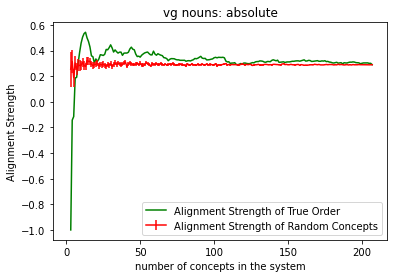

In [13]:
# glove language embeddings
plot_percentage_in_order("vg nouns: absolute",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=1,num_simulation=100,concept_accum=True,relative=False)

639.3279418945312
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.8303, 0.9482999999999998, 0.9932, 0.9983, 0.9990000000000001, 0.9999000000000001, 0.9999000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


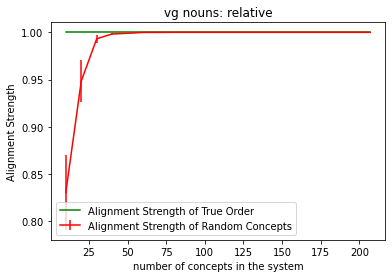

In [14]:
# glove language embeddings
plot_percentage_in_order("vg nouns: relative",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

97.4093370437622
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]
alignment true: [nan, nan, 0.5, 0.3142857142857143, 0.3

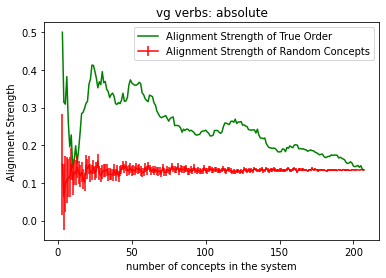

In [15]:
# glove language embeddings
plot_percentage_in_order("vg verbs: absolute",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=1,num_simulation=100,concept_accum=True,relative=False)

3958.8583760261536
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.78, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.7009000000000001, 0.7911000000000001, 0.8439, 0.8909999999999999, 0.9266, 0.9504, 0.9573, 0.9760000000000001, 0.9792000000000002, 0.9858, 0.9931, 0.9946, 0.9961000000000001, 0.9986, 0.9987999999999999, 0.9990000000000001, 0.9996, 0.9998, 1.0, 1.0, 1.0]


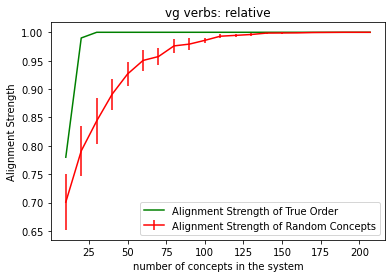

In [16]:
# glove language embeddings
plot_percentage_in_order("vg verbs: relative",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

-------------------

38.42691683769226
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]
alignment true: [nan, nan, -1.0, -0.14285714285714288,

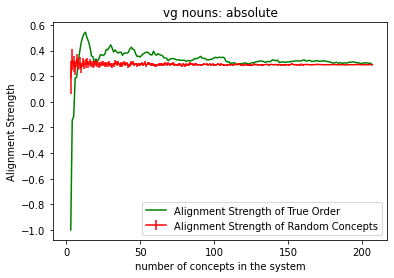

In [54]:
# unknown language embeddings
plot_percentage_in_order("vg nouns: absolute",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=1,num_simulation=100,concept_accum=True,relative=False)

1605.3735167980194
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.8643999999999998, 0.9455, 0.9867, 0.9934999999999999, 0.9984999999999999, 0.9996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


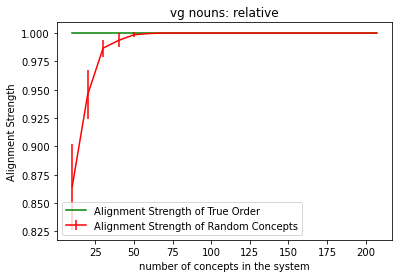

In [55]:
# unknown language embeddings
plot_percentage_in_order("vg nouns: relative",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

37.650787115097046
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207]
alignment true: [nan, nan, 0.5, 0.3142857142857143, 0

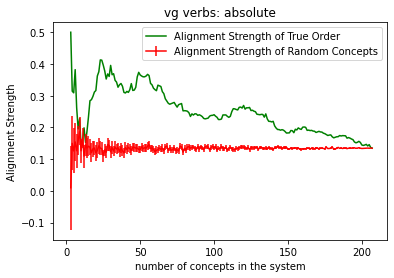

In [56]:
# unknown language embeddings
plot_percentage_in_order("vg verbs: absolute",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=1,num_simulation=100,concept_accum=True,relative=False)

1896.6829979419708
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.6658, 0.8106, 0.8112, 0.9087999999999999, 0.9357, 0.9470999999999999, 0.9648, 0.975, 0.9791999999999998, 0.9873999999999999, 0.9917, 0.9932000000000002, 0.9978, 0.9982000000000001, 0.9986999999999999, 0.9992, 0.9996, 0.9999000000000001, 1.0, 1.0, 1.0]


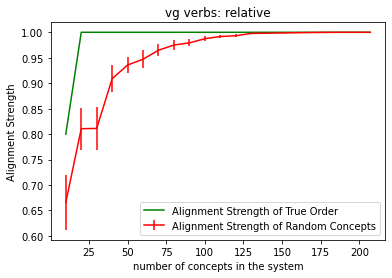

In [57]:
# unknown language embeddings
plot_percentage_in_order("vg verbs: relative",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

-------------------------------------------------------

5.7273499965667725
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [-0.152832674571805, -0.003570007042037905, 0.1718584942932077, 0.1242368400190816, 0.08404837954757759, 0.14295007892754727, 0.15445211455945665, 0.1708394575646274, 0.17606338269986466, 0.17596546442375172, 0.1525182069042559, 0.16339838431287612, 0.18095440690224782, 0.18519115270169154, 0.18366441810095321, 0.19300546526239823, 0.1749040388148683, 0.16667043606127677, 0.15710606809268027, 0.1505983847372039, 0.15370442864811168]
alignment shuffled: [0.16928194993412388, 0.181767140363999, 0.17856672336008203, 0.1489281406922653, 0.15090333464175704, 0.15561617087209698, 0.15999568132505082, 0.15164873924082067, 0.15168831466046742, 0.15357254681881996, 0.15790917479913016, 0.15485630537165657, 0.15268217608388054, 0.1512905771875236, 0.15418913157397113, 0.15322606283432477, 0.15379862053759236, 0.1531014371998233, 0.15470656586925133, 0.15363894472247

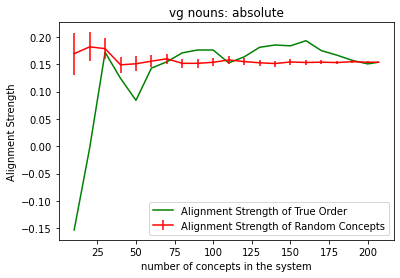

In [14]:
# bert language embeddings
plot_percentage_in_order("vg nouns: absolute",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=False)

532.9204511642456
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.27, 0.49, 0.95, 0.92, 0.85, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.7195999999999999, 0.7908, 0.8576, 0.9153000000000001, 0.9334, 0.9351, 0.9536, 0.9672, 0.9884000000000001, 0.9871, 0.9932, 0.9973000000000001, 0.9971, 0.9987, 0.9989, 0.9994, 0.9999000000000001, 1.0, 0.9995, 0.9999000000000001, 0.9999000000000001]


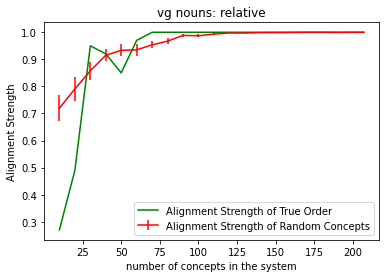

In [15]:
# bert language embeddings
plot_percentage_in_order("vg nouns: relative",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

4.963084697723389
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [-0.11436100131752303, 0.13837123349385683, 0.16631104605816566, 0.14238001958987692, 0.21228144765247045, 0.20575925126931094, 0.1809889860325211, 0.15441280101398078, 0.13659652206487669, 0.12683661230380935, 0.13202768955688135, 0.14415673888924865, 0.14271086575648279, 0.13995115351623216, 0.14787513076620118, 0.1510793600196988, 0.13756498340137002, 0.13738474710578055, 0.12860732574573755, 0.12224706597137115, 0.11438933197302466]
alignment shuffled: [0.13253623188405794, 0.1133599007805441, 0.1201327447786936, 0.12277618543117981, 0.10701916370708282, 0.12339538591584981, 0.11358526336373162, 0.10847226020601998, 0.11641689320213444, 0.11706206455865521, 0.1145748551237544, 0.11449153053906294, 0.11593765057016304, 0.1131690233146433, 0.11483261225429729, 0.11321962266912151, 0.10924519117874207, 0.11593723378091596, 0.1155043180632342, 0.11336543698

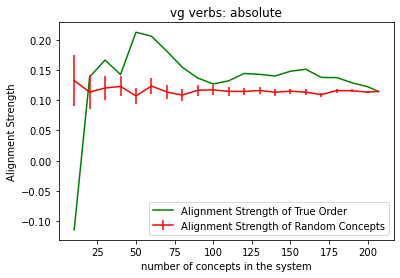

In [16]:
plot_percentage_in_order("vg verbs: absolute",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=False)

584.1979999542236
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.29, 0.76, 0.9, 0.96, 0.99, 1.0, 1.0, 1.0, 0.97, 0.97, 0.99, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 0.99, 1.0, 0.98, 1.0]
alignment shuffled: [0.6578, 0.7081999999999999, 0.7860999999999998, 0.8148000000000001, 0.8314999999999999, 0.8593, 0.9016999999999998, 0.9187000000000002, 0.937, 0.9390000000000001, 0.956, 0.9700000000000002, 0.9783999999999999, 0.9811, 0.9893, 0.9892, 0.9921, 0.9935, 0.9956, 0.9975000000000002, 0.9980000000000001]


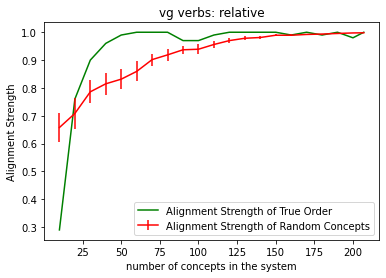

In [17]:
plot_percentage_in_order("vg verbs: relative",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

In [18]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_least10_bert_window51_10.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_least10_bert_window51_10.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,10,10)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,10,10)

7.228527069091797
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.11172595520421606, 0.06279310842551405, 0.22353715514461092, 0.15723359529388795, 0.07439380331968644, 0.12266862976893605, 0.15713405329748734, 0.208136089183084, 0.21797099607251258, 0.2182831988883928, 0.1808241604918265, 0.19099264701993368, 0.19673422366170906, 0.19289571009278098, 0.1729307627925846, 0.19080956114716452, 0.16538009785132632, 0.1563935753722569, 0.162434776416605, 0.1523433079105243, 0.14417560531021759]
alignment shuffled: [0.14273781291172594, 0.15035823415432126, 0.14720081013269048, 0.16069096665153565, 0.14408906002901792, 0.14361656476910623, 0.15341718863557194, 0.15085968137240735, 0.13397195970551806, 0.1507902151598876, 0.14442404941677034, 0.14529989023538376, 0.1439468839350007, 0.1422975321577369, 0.14261094169406704, 0.14213315167558616, 0.14236928026818693, 0.1445235651692196, 0.14462649547388304, 0.14499160988958534,

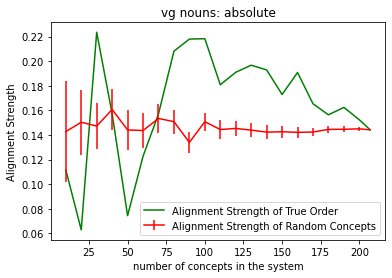

In [19]:
plot_percentage_in_order("vg nouns: absolute",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=False)

573.991781949997
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.71, 0.68, 0.97, 0.97, 0.84, 0.96, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.6840999999999999, 0.8242999999999999, 0.8202000000000002, 0.895, 0.9414000000000001, 0.9422000000000001, 0.9611, 0.9490000000000001, 0.9832000000000001, 0.9763, 0.9887, 0.9928999999999999, 0.9929000000000001, 0.9963000000000001, 0.9972, 0.9978999999999999, 0.9987999999999999, 0.9995, 0.9995, 0.9998, 0.9999000000000001]


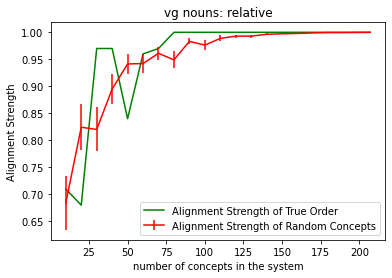

In [20]:
plot_percentage_in_order("vg nouns: relative",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

5.6657116413116455
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.01699604743083004, 0.12030862496555526, 0.13089773550632203, 0.080911375593977, 0.1650963158509733, 0.21867849251076227, 0.18977407576503552, 0.15683574586648308, 0.13260660760478452, 0.1422564226375256, 0.15167266943913285, 0.12379822154192338, 0.12517762595878182, 0.10070093326969971, 0.0983647061693676, 0.10444328715567143, 0.09908626885995495, 0.08316929648338539, 0.08234827016527681, 0.07381018542748843, 0.06886183225499329]
alignment shuffled: [0.060098814229249016, 0.04572141621109293, 0.07043065849674435, 0.07431306029868238, 0.08046681986952374, 0.0702853254545654, 0.07167256663361017, 0.06529538532046612, 0.07201316686346367, 0.06336186898748336, 0.06921936250274369, 0.06942060114144394, 0.07248956029353305, 0.06387579805014228, 0.07094492620440944, 0.0675168677870098, 0.06912703302881636, 0.06975384015398657, 0.06910688739917414, 0.0684577674

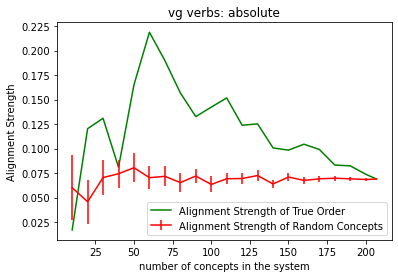

In [21]:
plot_percentage_in_order("vg verbs: absolute",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=False)

516.7266499996185
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 207]
alignment true: [0.57, 0.72, 0.96, 0.88, 0.98, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0, 0.99, 0.99, 0.99, 0.98, 1.0, 0.99, 1.0, 0.96, 0.96, 0.97]
alignment shuffled: [0.5937, 0.6861, 0.7041999999999998, 0.7136999999999999, 0.7766000000000001, 0.7591999999999999, 0.7904000000000001, 0.8310999999999998, 0.8064000000000001, 0.8702000000000001, 0.8650999999999999, 0.8865, 0.9028999999999998, 0.9084, 0.9117000000000002, 0.9322999999999999, 0.9386, 0.9404, 0.9555000000000001, 0.9628999999999999, 0.9649]


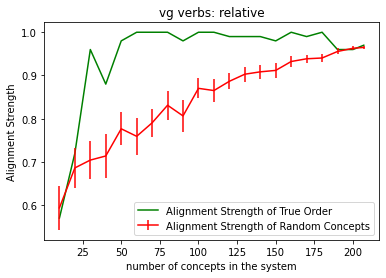

In [22]:
plot_percentage_in_order("vg verbs: relative",aggregated_vg_verb_data,list(list(zip(*verb_aoa_sorted))[0]),
                         step=10,num_simulation=100,concept_accum=True,relative=True)

-----------------------

613.4409127235413
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 306]
alignment true: [0.75, 0.9, 0.93, 0.98, 0.89, 0.92, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.6656666666666666, 0.724, 0.8753333333333333, 0.8093333333333332, 0.873, 0.9120000000000001, 0.9536666666666666, 0.9616666666666666, 0.9763333333333333, 0.961, 0.9756666666666667, 0.9913333333333332, 0.9853333333333333, 0.9916666666666666, 0.9966666666666666, 0.9866666666666666, 0.9983333333333333, 0.9949999999999999, 0.9960000000000001, 0.9963333333333334, 0.9993333333333333, 0.9986666666666666, 1.0, 0.9993333333333333, 0.9996666666666667, 0.9993333333333333, 1.0, 1.0, 1.0, 1.0, 1.0]


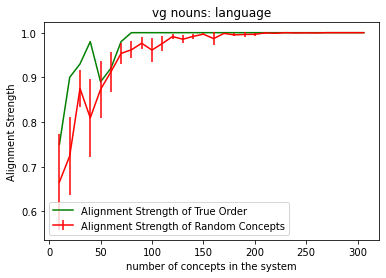

In [23]:
plot_percentage_in_order("vg nouns: language",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),step=10,num_simulation=30,concept_accum=True,relative=True)

30.75543212890625
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 162]
alignment true: [0.76, 0.72, 0.91, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alignment shuffled: [0.784, 0.921, 0.984, 0.9780000000000001, 0.992, 0.99, 0.993, 0.9960000000000001, 1.0, 0.999, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0]


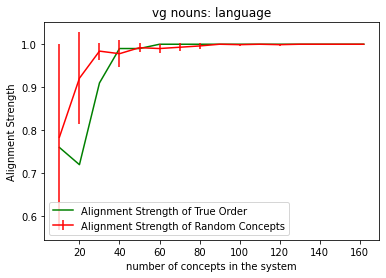

In [18]:
plot_percentage_in_order("vg nouns: language",aggregated_vg_noun_data,list(list(zip(*noun_aoa_sorted))[0]),step=10,num_simulation=10,concept_accum=True,relative=True)